In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall:

In [2]:
# model.eval()
# dummy_input = torch.randn(1, 3, 224, 224).cuda()
# torch.onnx.export(model, dummy_input, "fall_model.onnx")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from tqdm import tqdm
import cv2
import time
from ultralytics import YOLO
from collections import deque
from PIL import Image

# Thiết lập device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Thiết lập các tham số
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 40
LEARNING_RATE = 0.001
NUM_CLASSES = 2

# Đường dẫn đến thư mục dữ liệu
DATA_DIR = '/kaggle/input/d/ltlongg/fall-dataset/cnn_fall'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DIR = os.path.join(DATA_DIR, 'test')



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


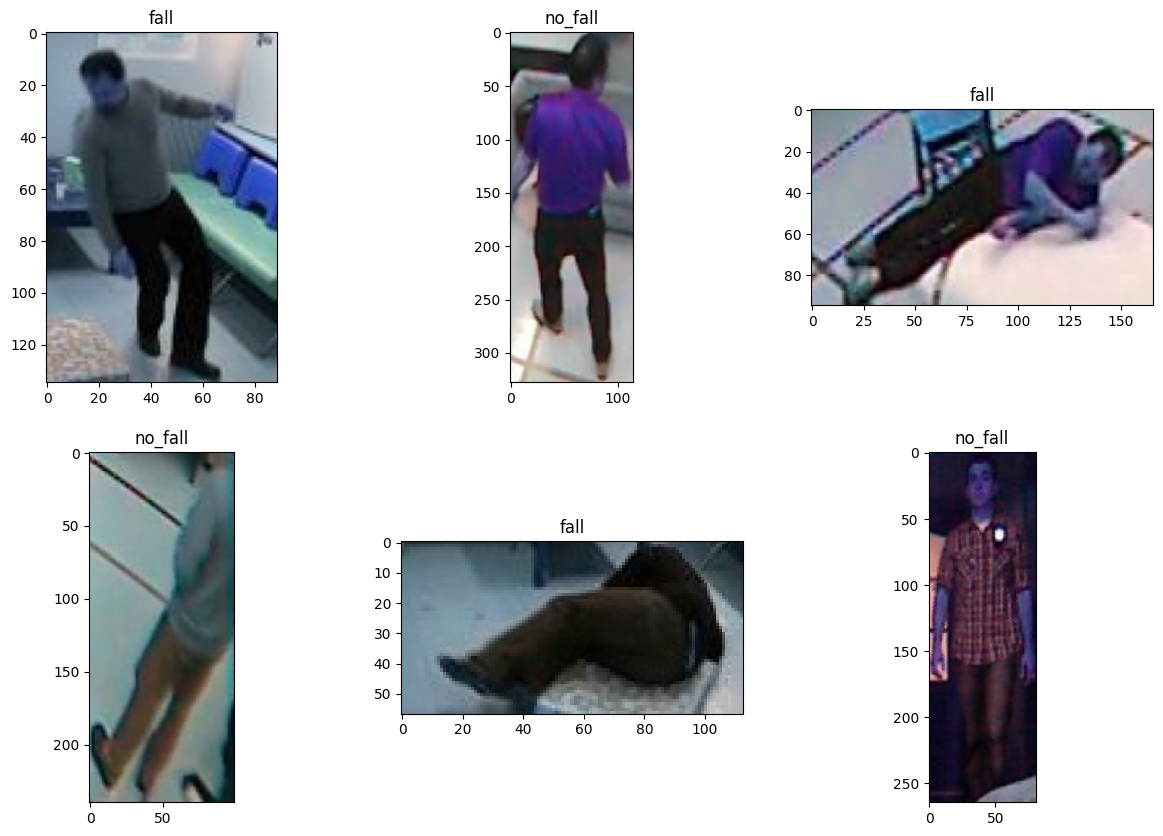

In [4]:
fig, axs = plt.subplots(2,3, figsize = (15,10))
img_fall_list = os.listdir(os.path.join(TRAIN_DIR, 'fall'))
img_nofall_list = os.listdir(os.path.join(TRAIN_DIR, 'no_fall'))
axs_flatten = axs.flatten()
for i in range (6):
    if i%2==0:
       img = cv2.imread(os.path.join(os.path.join(TRAIN_DIR, 'fall'),img_fall_list[i]))
       axs_flatten[i].imshow(img)
       axs_flatten[i].set_title('fall')
    else:
       img = cv2.imread(os.path.join(os.path.join(TRAIN_DIR, 'no_fall'),img_nofall_list[i]))
       axs_flatten[i].imshow(img)
       axs_flatten[i].set_title('no_fall')

In [5]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_HEIGHT, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets với cấu trúc thư mục của bạn
print("Đang load dataset với cấu trúc:")
print("cnn_fall/")
print("├── train/")
print("│   ├── fall/      <- Ảnh người bị ngã")
print("│   └── no_fall/   <- Ảnh người không ngã")
print("├── val/")
print("│   ├── fall/")
print("│   └── no_fall/")
print("└── test/")
print("    ├── fall/")
print("    └── no_fall/")
print()

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Classes detected: {train_dataset.classes}')
print(f'Class to index mapping: {train_dataset.class_to_idx}')



Đang load dataset với cấu trúc:
cnn_fall/
├── train/
│   ├── fall/      <- Ảnh người bị ngã
│   └── no_fall/   <- Ảnh người không ngã
├── val/
│   ├── fall/
│   └── no_fall/
└── test/
    ├── fall/
    └── no_fall/

Training samples: 8244
Validation samples: 867
Test samples: 672
Classes detected: ['fall', 'no_fall']
Class to index mapping: {'fall': 0, 'no_fall': 1}


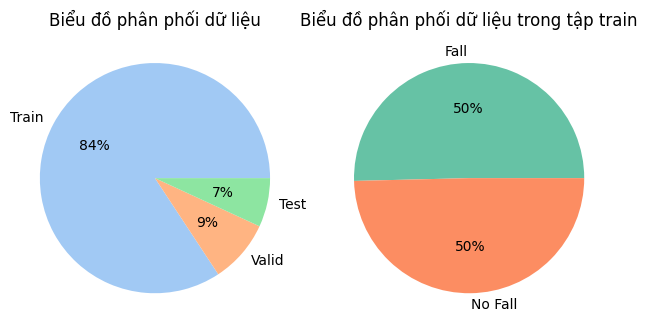

In [6]:
count_train = len(train_dataset)
count_val = len(val_dataset)
count_test = len(test_dataset)

list_count = [count_train, count_val, count_test]
labels = ['Train', 'Valid', 'Test']
colors = sns.color_palette('pastel')

plt.subplot(121)
plt.pie(list_count, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Biểu đồ phân phối dữ liệu')

count_fall_in_train = len(os.listdir(os.path.join(TRAIN_DIR, 'fall')))
count_nofall_in_train = len(os.listdir(os.path.join(TRAIN_DIR, 'no_fall')))
count_data_in_train = [count_fall_in_train, count_nofall_in_train]
labels = ['Fall', 'No Fall']
colors = sns.color_palette('Set2')

plt.subplot(122)
plt.pie(count_data_in_train, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Biểu đồ phân phối dữ liệu trong tập train')

plt.tight_layout()
plt.show()

In [7]:
# Định nghĩa mô hình CNN
class FallDetectionCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(FallDetectionCNN, self).__init__()

        # Block 1
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)

        # Block 2
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)

        # Block 3
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)

        # Block 4
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(0.25)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # 224/16 = 14
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout_fc2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.bn4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        # Fully Connected
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = self.fc3(x)

        return x

# Khởi tạo mô hình
model = FallDetectionCNN(num_classes=NUM_CLASSES).to(device)

# Loss function và optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=0.0001)

# In thông tin mô hình
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model has {count_parameters(model):,} trainable parameters')


Model has 26,996,706 trainable parameters


In [8]:
fd_net = FallDetectionCNN().to(device)
summary(fd_net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]           9,248
       BatchNorm2d-3         [-1, 32, 224, 224]              64
         MaxPool2d-4         [-1, 32, 112, 112]               0
         Dropout2d-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
            Conv2d-7         [-1, 64, 112, 112]          36,928
       BatchNorm2d-8         [-1, 64, 112, 112]             128
         MaxPool2d-9           [-1, 64, 56, 56]               0
        Dropout2d-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
           Conv2d-12          [-1, 128, 56, 56]         147,584
      BatchNorm2d-13          [-1, 128, 56, 56]             256
        MaxPool2d-14          [-1, 128,

In [9]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'Loss': f'{running_loss/(progress_bar.n+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({
                'Loss': f'{running_loss/(progress_bar.n+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

# Training loop
print("Bắt đầu training...")
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
patience_counter = 0
patience = 10

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print('-' * 50)

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_fall_detection_model.pth')
        print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break



Bắt đầu training...

Epoch 1/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:02<00:00, 12.67it/s, Loss=0.3162, Acc=87.89%]


Train Loss: 0.3978, Train Acc: 81.21%
Val Loss: 0.2936, Val Acc: 87.89%
Current LR: 0.001000
New best model saved with validation accuracy: 87.89%

Epoch 2/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.33it/s, Loss=0.4308, Acc=82.70%]


Train Loss: 0.2829, Train Acc: 87.93%
Val Loss: 0.4000, Val Acc: 82.70%
Current LR: 0.001000

Epoch 3/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.80it/s, Loss=0.2649, Acc=89.50%]


Train Loss: 0.2516, Train Acc: 89.50%
Val Loss: 0.2649, Val Acc: 89.50%
Current LR: 0.001000
New best model saved with validation accuracy: 89.50%

Epoch 4/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.83it/s, Loss=0.2513, Acc=91.12%]


Train Loss: 0.2321, Train Acc: 90.48%
Val Loss: 0.2333, Val Acc: 91.12%
Current LR: 0.001000
New best model saved with validation accuracy: 91.12%

Epoch 5/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.41it/s, Loss=0.3458, Acc=87.08%]


Train Loss: 0.2217, Train Acc: 91.06%
Val Loss: 0.3458, Val Acc: 87.08%
Current LR: 0.001000

Epoch 6/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.16it/s, Loss=0.2451, Acc=90.89%]


Train Loss: 0.2154, Train Acc: 91.42%
Val Loss: 0.2451, Val Acc: 90.89%
Current LR: 0.001000

Epoch 7/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.51it/s, Loss=0.1983, Acc=91.58%]


Train Loss: 0.2071, Train Acc: 91.91%
Val Loss: 0.1983, Val Acc: 91.58%
Current LR: 0.001000
New best model saved with validation accuracy: 91.58%

Epoch 8/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.45it/s, Loss=0.2135, Acc=91.46%]


Train Loss: 0.1889, Train Acc: 92.73%
Val Loss: 0.2135, Val Acc: 91.46%
Current LR: 0.001000

Epoch 9/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.43it/s, Loss=0.2159, Acc=92.27%]


Train Loss: 0.1949, Train Acc: 92.26%
Val Loss: 0.2005, Val Acc: 92.27%
Current LR: 0.001000
New best model saved with validation accuracy: 92.27%

Epoch 10/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.70it/s, Loss=0.2052, Acc=92.73%]


Train Loss: 0.1814, Train Acc: 93.39%
Val Loss: 0.1906, Val Acc: 92.73%
Current LR: 0.001000
New best model saved with validation accuracy: 92.73%

Epoch 11/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.07it/s, Loss=0.2118, Acc=92.04%]


Train Loss: 0.1782, Train Acc: 92.99%
Val Loss: 0.2118, Val Acc: 92.04%
Current LR: 0.001000

Epoch 12/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.81it/s, Loss=0.1861, Acc=92.62%]


Train Loss: 0.1707, Train Acc: 93.32%
Val Loss: 0.1861, Val Acc: 92.62%
Current LR: 0.001000

Epoch 13/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.23it/s, Loss=0.1964, Acc=92.16%]


Train Loss: 0.1590, Train Acc: 93.89%
Val Loss: 0.1824, Val Acc: 92.16%
Current LR: 0.001000

Epoch 14/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.09it/s, Loss=0.1760, Acc=92.85%]


Train Loss: 0.1603, Train Acc: 94.06%
Val Loss: 0.1760, Val Acc: 92.85%
Current LR: 0.001000
New best model saved with validation accuracy: 92.85%

Epoch 15/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.23it/s, Loss=0.2108, Acc=92.85%]


Train Loss: 0.1580, Train Acc: 93.80%
Val Loss: 0.2108, Val Acc: 92.85%
Current LR: 0.001000

Epoch 16/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.59it/s, Loss=0.1865, Acc=92.62%]


Train Loss: 0.1580, Train Acc: 94.38%
Val Loss: 0.1732, Val Acc: 92.62%
Current LR: 0.001000

Epoch 17/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.06it/s, Loss=0.1931, Acc=92.39%]


Train Loss: 0.1365, Train Acc: 94.94%
Val Loss: 0.1931, Val Acc: 92.39%
Current LR: 0.001000

Epoch 18/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.21it/s, Loss=0.1558, Acc=93.77%]


Train Loss: 0.1437, Train Acc: 94.72%
Val Loss: 0.1558, Val Acc: 93.77%
Current LR: 0.001000
New best model saved with validation accuracy: 93.77%

Epoch 19/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.03it/s, Loss=0.1822, Acc=93.31%]


Train Loss: 0.1465, Train Acc: 94.40%
Val Loss: 0.1822, Val Acc: 93.31%
Current LR: 0.001000

Epoch 20/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.51it/s, Loss=0.1980, Acc=93.31%]


Train Loss: 0.1424, Train Acc: 94.43%
Val Loss: 0.1980, Val Acc: 93.31%
Current LR: 0.001000

Epoch 21/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.21it/s, Loss=0.1569, Acc=94.58%]


Train Loss: 0.1445, Train Acc: 94.60%
Val Loss: 0.1569, Val Acc: 94.58%
Current LR: 0.001000
New best model saved with validation accuracy: 94.58%

Epoch 22/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.53it/s, Loss=0.1815, Acc=93.89%]


Train Loss: 0.1273, Train Acc: 95.44%
Val Loss: 0.1685, Val Acc: 93.89%
Current LR: 0.001000

Epoch 23/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.64it/s, Loss=0.1759, Acc=94.00%]


Train Loss: 0.1334, Train Acc: 94.88%
Val Loss: 0.1634, Val Acc: 94.00%
Current LR: 0.001000

Epoch 24/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.02it/s, Loss=0.2100, Acc=93.77%]


Train Loss: 0.1422, Train Acc: 94.66%
Val Loss: 0.2100, Val Acc: 93.77%
Current LR: 0.000200

Epoch 25/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.65it/s, Loss=0.1652, Acc=93.31%]


Train Loss: 0.1214, Train Acc: 95.22%
Val Loss: 0.1534, Val Acc: 93.31%
Current LR: 0.000200

Epoch 26/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.46it/s, Loss=0.1478, Acc=93.89%]


Train Loss: 0.1113, Train Acc: 95.72%
Val Loss: 0.1478, Val Acc: 93.89%
Current LR: 0.000200

Epoch 27/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.26it/s, Loss=0.1436, Acc=94.58%]


Train Loss: 0.1029, Train Acc: 96.12%
Val Loss: 0.1385, Val Acc: 94.58%
Current LR: 0.000200

Epoch 28/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.21it/s, Loss=0.1488, Acc=94.46%]


Train Loss: 0.1024, Train Acc: 96.19%
Val Loss: 0.1382, Val Acc: 94.46%
Current LR: 0.000200

Epoch 29/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.26it/s, Loss=0.1293, Acc=94.81%]


Train Loss: 0.0986, Train Acc: 96.32%
Val Loss: 0.1293, Val Acc: 94.81%
Current LR: 0.000200
New best model saved with validation accuracy: 94.81%

Epoch 30/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.35it/s, Loss=0.1362, Acc=94.58%]


Train Loss: 0.0979, Train Acc: 96.62%
Val Loss: 0.1362, Val Acc: 94.58%
Current LR: 0.000200

Epoch 31/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.30it/s, Loss=0.1391, Acc=94.81%]


Train Loss: 0.0953, Train Acc: 96.39%
Val Loss: 0.1391, Val Acc: 94.81%
Current LR: 0.000200

Epoch 32/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.35it/s, Loss=0.1389, Acc=95.16%]


Train Loss: 0.0958, Train Acc: 96.54%
Val Loss: 0.1389, Val Acc: 95.16%
Current LR: 0.000200
New best model saved with validation accuracy: 95.16%

Epoch 33/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.13it/s, Loss=0.1284, Acc=94.93%]


Train Loss: 0.0951, Train Acc: 96.36%
Val Loss: 0.1284, Val Acc: 94.93%
Current LR: 0.000200

Epoch 34/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.30it/s, Loss=0.1319, Acc=94.69%]


Train Loss: 0.0857, Train Acc: 96.86%
Val Loss: 0.1319, Val Acc: 94.69%
Current LR: 0.000200

Epoch 35/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.60it/s, Loss=0.1278, Acc=95.16%]


Train Loss: 0.0826, Train Acc: 96.82%
Val Loss: 0.1278, Val Acc: 95.16%
Current LR: 0.000200

Epoch 36/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 17.86it/s, Loss=0.1257, Acc=95.50%]


Train Loss: 0.0861, Train Acc: 97.00%
Val Loss: 0.1257, Val Acc: 95.50%
Current LR: 0.000200
New best model saved with validation accuracy: 95.50%

Epoch 37/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 16.95it/s, Loss=0.1430, Acc=95.27%]


Train Loss: 0.0784, Train Acc: 97.02%
Val Loss: 0.1379, Val Acc: 95.27%
Current LR: 0.000200

Epoch 38/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.38it/s, Loss=0.1285, Acc=95.04%]


Train Loss: 0.0836, Train Acc: 96.85%
Val Loss: 0.1285, Val Acc: 95.04%
Current LR: 0.000200

Epoch 39/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.48it/s, Loss=0.1212, Acc=95.16%]


Train Loss: 0.0828, Train Acc: 97.03%
Val Loss: 0.1212, Val Acc: 95.16%
Current LR: 0.000200

Epoch 40/40
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:01<00:00, 18.00it/s, Loss=0.1557, Acc=95.85%]


Train Loss: 0.0834, Train Acc: 97.15%
Val Loss: 0.1501, Val Acc: 95.85%
Current LR: 0.000200
New best model saved with validation accuracy: 95.85%


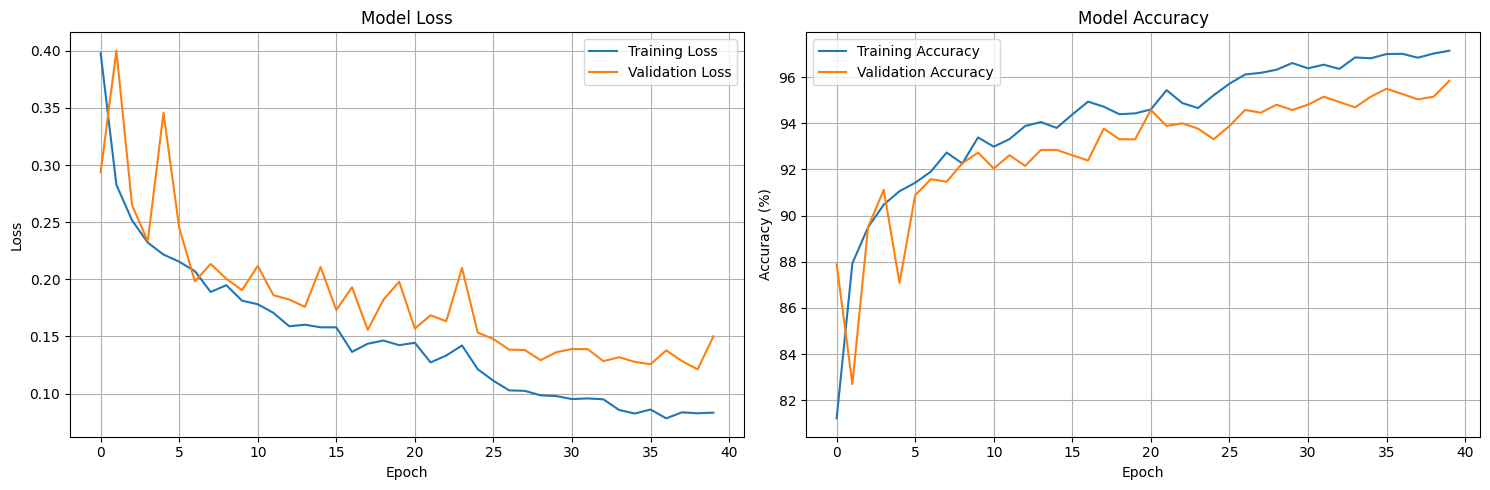

In [10]:
# Plot training history
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)




Loading best model for testing...


Validation: 100%|██████████| 21/21 [00:01<00:00, 15.79it/s, Loss=0.0944, Acc=97.32%]



Test Results:
Test Loss: 0.0854
Test Accuracy: 97.32%


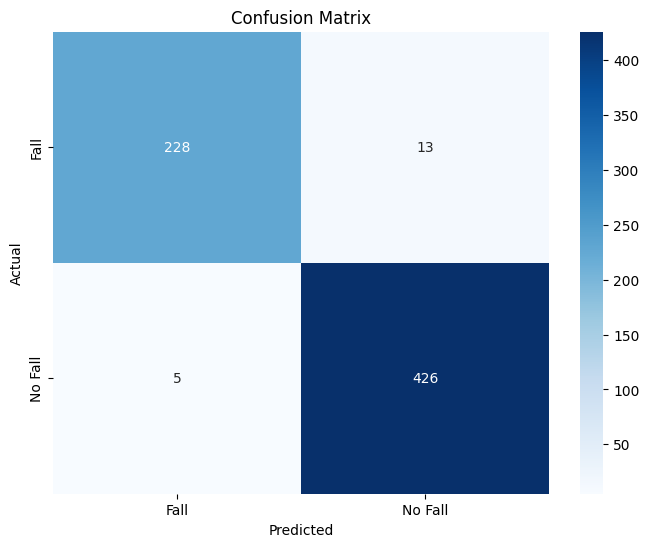


Classification Report:
              precision    recall  f1-score   support

        Fall       0.98      0.95      0.96       241
     No Fall       0.97      0.99      0.98       431

    accuracy                           0.97       672
   macro avg       0.97      0.97      0.97       672
weighted avg       0.97      0.97      0.97       672



In [20]:
# Load best model và test
print("\nLoading best model for testing...")
model.load_state_dict(torch.load('/kaggle/input/weight/best_fall_detection_model.pth'))

# Test evaluation
test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
class_names = ['Fall', 'No Fall']
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))



In [21]:
# ========== REAL-TIME PREDICTION FUNCTIONS ==========
# Khởi tạo YOLO model
print("Đang tải YOLOv8 model...")
yolo_model = YOLO('yolov8n.pt')
print("YOLOv8 model đã được tải thành công!")

Đang tải YOLOv8 model...
YOLOv8 model đã được tải thành công!


In [ ]:
model

In [22]:
# Hàm dự đoán cho ảnh mới
def predict_image(model, image_path, device, transform):
    """
    Dự đoán một ảnh có phải là fall hay không
    """

    # Load và preprocess ảnh
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    class_names = ['Fall', 'No Fall']
    result = class_names[predicted.item()]
    confidence_score = confidence.item()
    print('Result: ', result)
    print('Confidence Score: ', confidence_score)
    
    return image



In [23]:
def detect_persons_yolov8(frame, confidence_threshold=0.5):
    """
    Detect người trong frame bằng YOLOv8
    Trả về list các bounding box [x1, y1, x2, y2] của người
    """
    results = yolo_model(frame, verbose=False)  # verbose=False để tắt log
    person_boxes = []

    for r in results:
        boxes = r.boxes
        if boxes is not None:
            for box in boxes:
                cls = int(box.cls)
                conf = float(box.conf)
                if cls == 0 and conf > confidence_threshold:  # Class 0 là 'person' trong COCO
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    # Đảm bảo tọa độ hợp lệ
                    if x2 > x1 and y2 > y1:
                        person_boxes.append([x1, y1, x2, y2])

    return person_boxes

In [24]:
def predict_image_with_yolo(model, image_path, device, transform, yolo_confidence=0.5):
    """
    Dự đoán ảnh với YOLOv8 person detection trước
    """

    # Load ảnh
    image_cv = cv2.imread(image_path)
    if image_cv is None:
        print(f"Không thể load ảnh: {image_path}")
        return None

    # Detect persons trong ảnh
    person_boxes = detect_persons_yolov8(image_cv, yolo_confidence)

    if not person_boxes:
        print("Không detect được người nào trong ảnh!")
        # Fallback: dự đoán toàn bộ ảnh
        print("Đang dự đoán toàn bộ ảnh...")
        return predict_image(model, image_path, device, transform)

    print(f"Detected {len(person_boxes)} person(s)")

    results = []
    for i, box in enumerate(person_boxes):
        x1, y1, x2, y2 = box

        # Crop person từ ảnh
        person_crop = image_cv[y1:y2, x1:x2]

        if person_crop.size == 0:
            continue

        # Resize và preprocess
        person_crop_resized = cv2.resize(person_crop, (224, 224))
        person_rgb = cv2.cvtColor(person_crop_resized, cv2.COLOR_BGR2RGB)

        # Convert to PIL và predict
        pil_image = Image.fromarray(person_rgb)
        image_tensor = transform(pil_image).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            # print('outputs:', outputs)
            probabilities = F.softmax(outputs, dim=1)
            # print('probabilities', probabilities)
            confidence, predicted = torch.max(probabilities, 1)
            # print('confidence:', confidence)
            # print('predicted:', predicted)
        class_names = ['Fall', 'No Fall']
        result = class_names[predicted.item()]
        confidence_score = confidence.item()
        fall_prob = probabilities[0][0].item()
   
        results.append({
            'person_id': i + 1,
            'box': box,
            'result': result,
            'confidence': confidence_score,
            'fall_prob': fall_prob
        })
    # Xác định màu dựa trên prediction
        if result == "Fall":
            color = (255, 0, 0)  # Đỏ - Fall detected
            thickness = 3
        else:
            color = (0, 255, 0)  # Xanh lá - No fall
            thickness = 2

        # Vẽ bounding box
        cv2.rectangle(image_cv, (x1, y1), (x2, y2), color, thickness)
        # Vẽ prediction text
        text = f"P{i+1}: {result} ({confidence_score:.2f})"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]

        # Background cho text
        cv2.rectangle(image_cv, (x1, y1 - text_size[1] - 10),
                     (x1 + text_size[0] + 10, y1), color, -1)
        cv2.putText(image_cv, text, (x1 + 5, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # print(f"Person {i+1}: {result} (confidence: {confidence_score:.4f}, fall_prob: {fall_prob:.4f})")

    return image_cv


Detected 9 person(s)
Detected 1 person(s)
Detected 1 person(s)
Result:  Fall
Confidence Score:  0.9881771206855774
Result:  No Fall
Confidence Score:  0.9999923706054688
Result:  Fall
Confidence Score:  0.9998090863227844


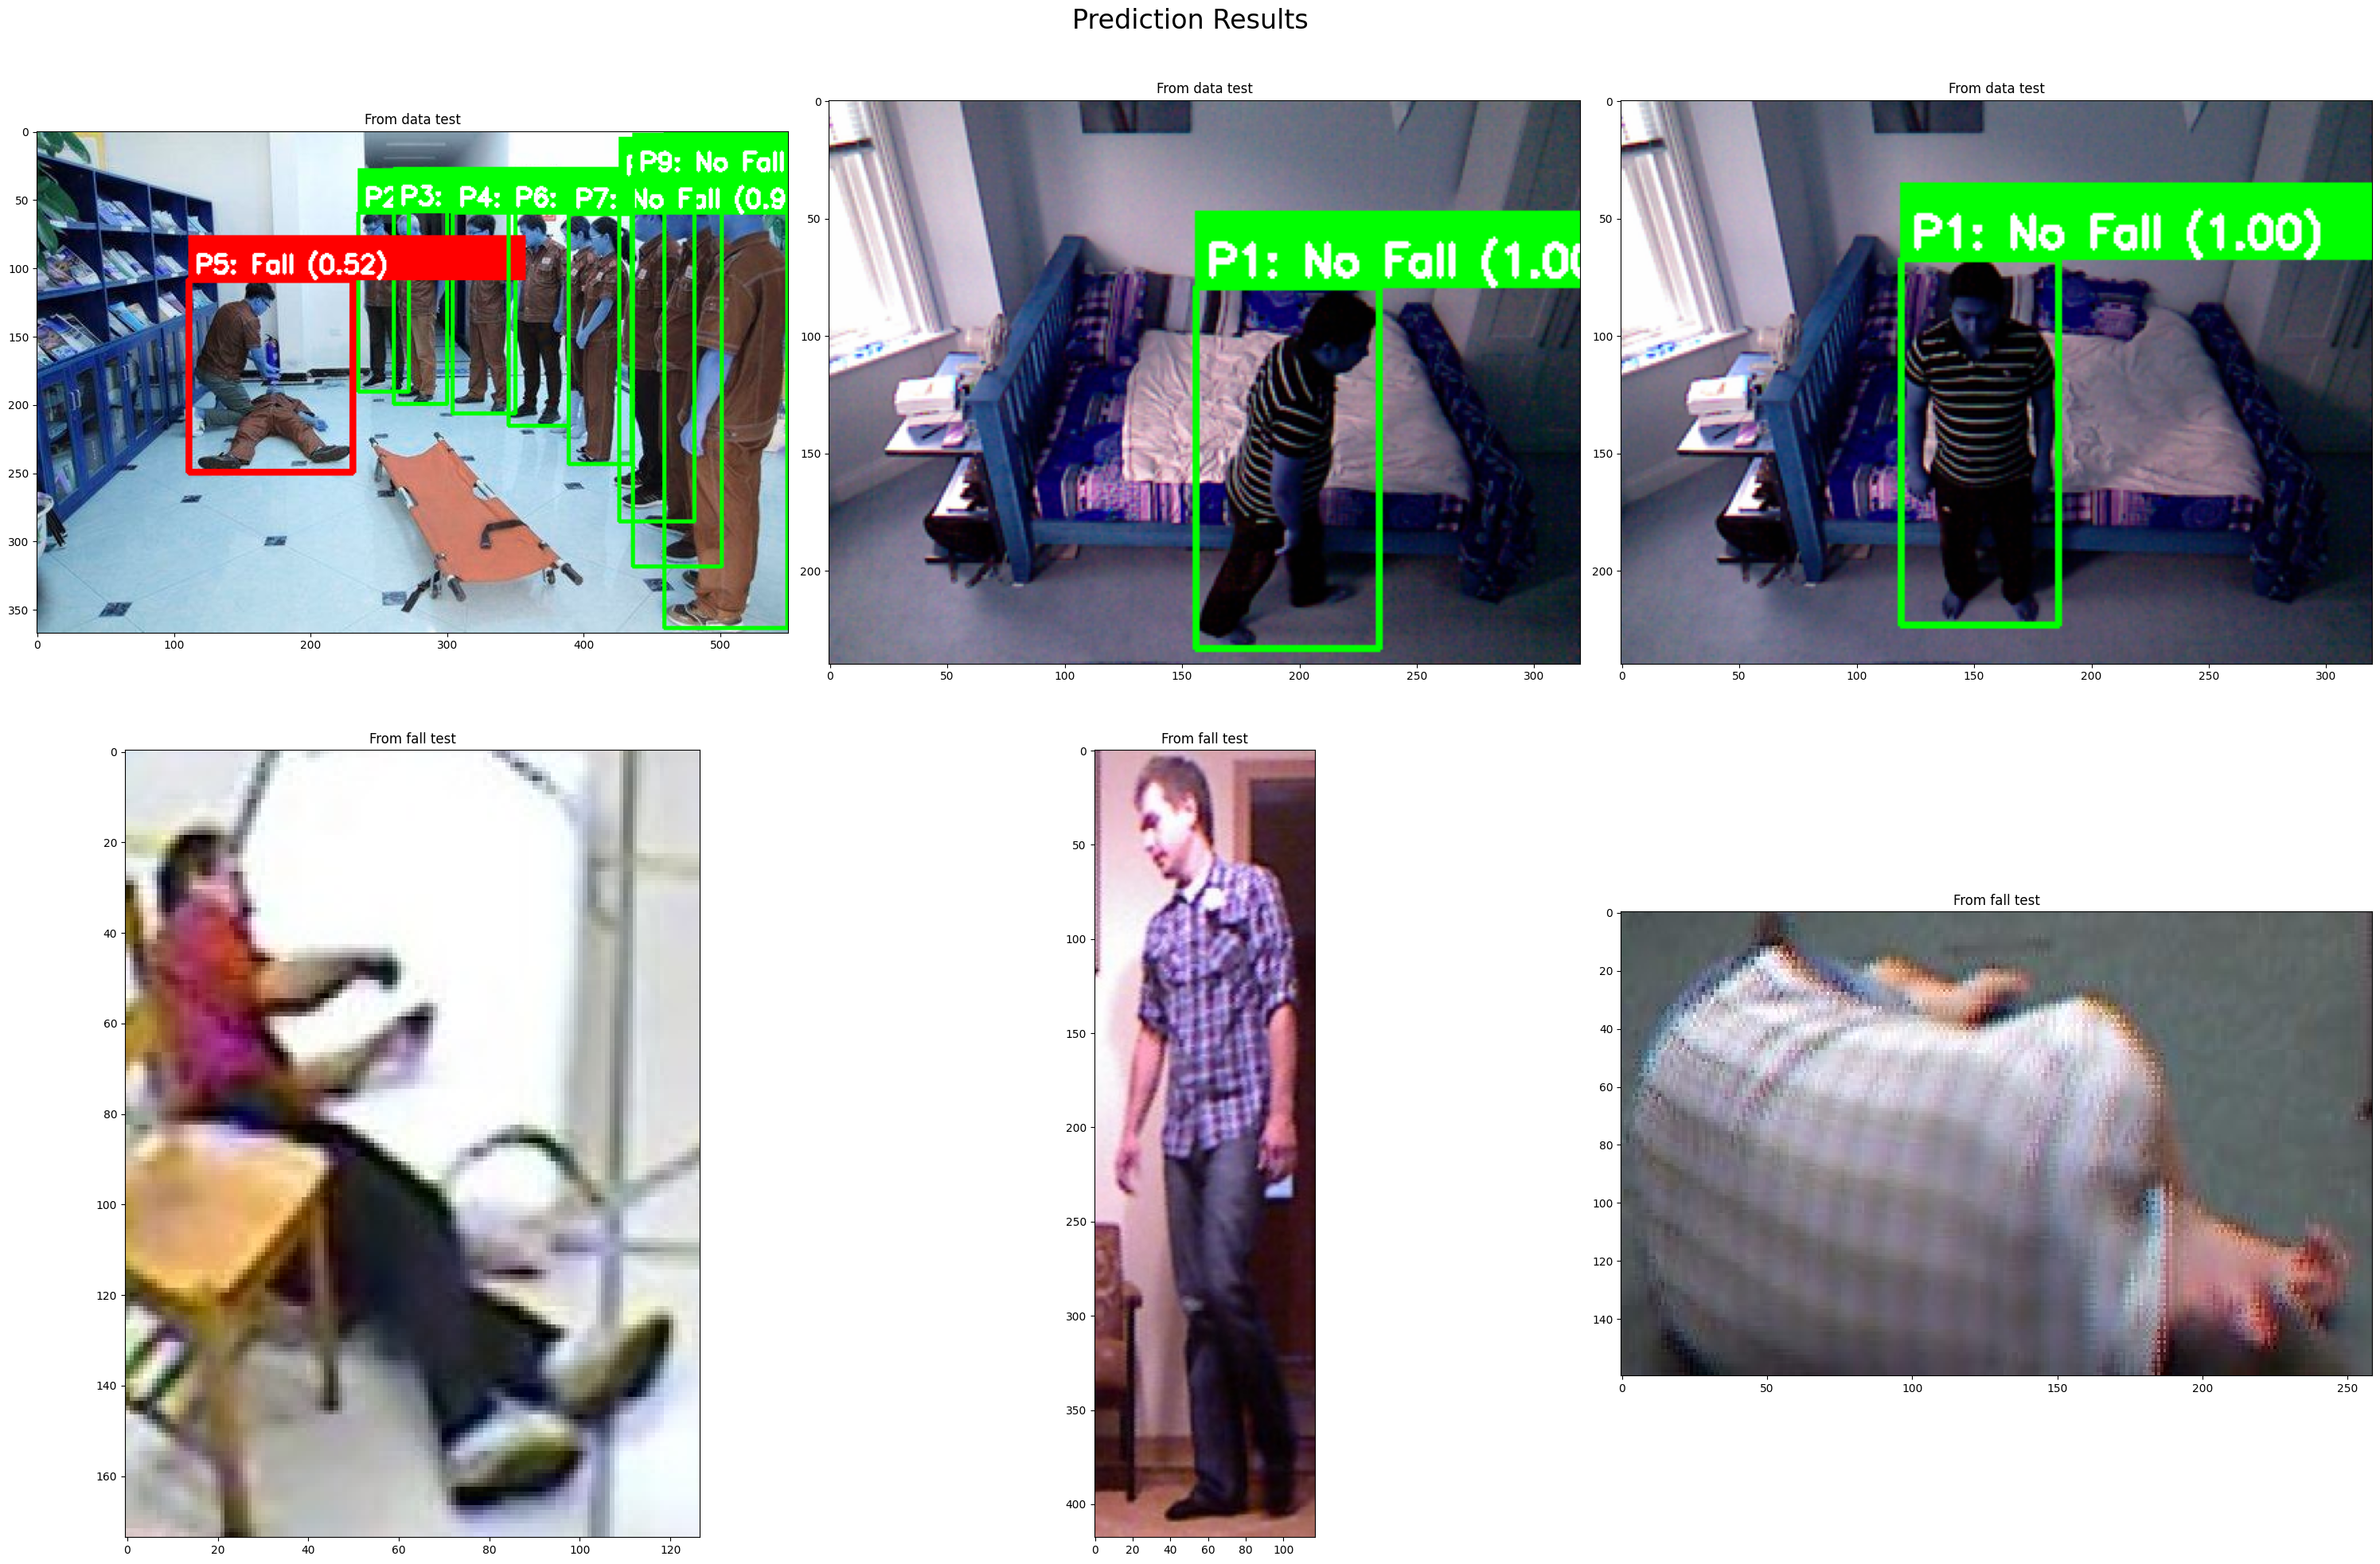

In [25]:
data_test_path = '/kaggle/input/data-test'
fall_test_path = ['/kaggle/input/d/ltlongg/fall-dataset/cnn_fall/test/fall/shuchu10_mp4-0110_jpg.rf.f8c20b63c12df539a0a208447f6bed26.jpg', '/kaggle/input/d/ltlongg/fall-dataset/cnn_fall/test/no_fall/adl-03-cam0-rgb-056_png.rf.88ff971d1d5e42d58f3e4df75ba58813.jpg', '/kaggle/input/d/ltlongg/fall-dataset/cnn_fall/test/fall/fall-05-cam0-rgb-140_png.rf.149cb3c32fbf41884f3612396fbad57d.jpg'] 
fig, axs = plt.subplots(2,3,figsize = (30,20))
axs_flatten = axs.flatten()
i = 0
for img in os.listdir(data_test_path):
    if img.endswith('jpg') or img.endswith('png'):
        img_test_path = os.path.join(data_test_path, img)
        img = predict_image_with_yolo(model, img_test_path, device, val_test_transform, yolo_confidence=0.5)
        axs_flatten[i].imshow(img)
        axs_flatten[i].set_title('From data test')
        i+=1
for img_path in fall_test_path :
    if img_path.endswith('jpg') or img_path.endswith('png'):
        img_test_path = img_path
        img = predict_image(model, img_test_path, device, val_test_transform)
        axs_flatten[i].imshow(img)
        axs_flatten[i].set_title('From fall test')
        i+=1
plt.tight_layout()
plt.suptitle('Prediction Results', fontsize=24)
plt.show()

In [26]:
def predict_frame_with_yolo_detection(model, frame, device, transform, yolo_confidence=0.5):
    """
    Dự đoán frame với YOLOv8 person detection
    """
    # Detect persons trong frame
    person_boxes = detect_persons_yolov8(frame, yolo_confidence)

    if not person_boxes:
        return []  # Không có người được detect

    predictions = []

    for i, box in enumerate(person_boxes):
        x1, y1, x2, y2 = box

        # Đảm bảo box nằm trong frame
        height, width = frame.shape[:2]
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)

        # Kiểm tra kích thước minimum
        box_width = x2 - x1
        box_height = y2 - y1

        if box_width > 50 and box_height > 50:  # Minimum size threshold
            # Crop person từ frame
            person_crop = frame[y1:y2, x1:x2]

            try:
                # Resize để phù hợp với training data
                person_crop_resized = cv2.resize(person_crop, (224, 224))

                # Convert BGR to RGB
                person_rgb = cv2.cvtColor(person_crop_resized, cv2.COLOR_BGR2RGB)

                # Convert to PIL và apply transform
                pil_image = Image.fromarray(person_rgb)
                image_tensor = transform(pil_image).unsqueeze(0).to(device)

                # Predict
                model.eval()
                with torch.no_grad():
                    outputs = model(image_tensor)
                    probabilities = F.softmax(outputs, dim=1)
                    confidence, predicted = torch.max(probabilities, 1)

                class_names = ['Fall', 'No Fall']
                result = class_names[predicted.item()]
                confidence_score = confidence.item()
                fall_prob = probabilities[0][0].item()

                predictions.append({
                    'person_id': i,
                    'box': [x1, y1, x2, y2],
                    'result': result,
                    'confidence': confidence_score,
                    'fall_prob': fall_prob
                })

            except Exception as e:
                print(f"Lỗi khi xử lý person {i}: {e}")
                continue

    return predictions



In [27]:
def real_time_webcam_prediction_yolo(model_path, device, transform,
                                   fall_confidence_threshold=0.7,
                                   yolo_confidence=0.5,
                                   buffer_size=5):
    """
    Dự đoán real-time từ webcam với YOLOv8 person detection
    """
    # Load fall detection model
    print("Đang tải Fall Detection model...")
    model = FallDetectionCNN(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Fall Detection model đã được tải!")

    # Khởi tạo webcam
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Không thể mở webcam!")
        return

    # Thiết lập webcam
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    cap.set(cv2.CAP_PROP_FPS, 30)

    # Buffer để smooth predictions cho từng person
    prediction_buffers = {}

    print("Bắt đầu dự đoán real-time từ webcam...")
    print("Hướng dẫn:")
    print("   - Nhấn 'q' để thoát")
    print("   - Nhấn 's' để chụp screenshot")
    print("   - Nhấn 'r' để reset buffers")

    fps_start_time = time.time()
    fps_counter = 0
    screenshot_counter = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Không thể đọc frame từ webcam!")
            break

        # Dự đoán với YOLOv8 person detection
        predictions = predict_frame_with_yolo_detection(
            model, frame, device, transform, yolo_confidence
        )

        # Vẽ predictions
        for pred in predictions:
            person_id = pred['person_id']
            x1, y1, x2, y2 = pred['box']
            result = pred['result']
            confidence = pred['confidence']
            fall_prob = pred['fall_prob']

            # Smooth prediction cho person này
            buffer_key = f"person_{person_id}"
            if buffer_key not in prediction_buffers:
                prediction_buffers[buffer_key] = deque(maxlen=buffer_size)

            prediction_buffers[buffer_key].append(fall_prob)
            avg_fall_prob = sum(prediction_buffers[buffer_key]) / len(prediction_buffers[buffer_key])
            smooth_result = "Fall" if avg_fall_prob > 0.5 else "No Fall"

            # Xác định màu dựa trên prediction
            if smooth_result == "Fall" and avg_fall_prob > fall_confidence_threshold:
                color = (0, 0, 255)  # Đỏ - Fall detected
                thickness = 3
            elif smooth_result == "Fall":
                color = (0, 165, 255)  # Cam - Fall possible
                thickness = 2
            else:
                color = (0, 255, 0)  # Xanh lá - No fall
                thickness = 2

            # Vẽ bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)

            # Vẽ prediction text
            text = f"P{person_id+1}: {smooth_result} ({avg_fall_prob:.2f})"
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]

            # Background cho text
            cv2.rectangle(frame, (x1, y1 - text_size[1] - 10),
                         (x1 + text_size[0] + 10, y1), color, -1)
            cv2.putText(frame, text, (x1 + 5, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            # Warning nếu phát hiện fall
            if smooth_result == "Fall" and avg_fall_prob > fall_confidence_threshold:
                warning_text = f"PERSON {person_id+1} FALL DETECTED!"
                cv2.putText(frame, warning_text, (x1, y2 + 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Thông tin tổng quan
        info_y = 25
        cv2.putText(frame, f"Persons detected: {len(predictions)}", (10, info_y),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Tính và hiển thị FPS
        fps_counter += 1
        if fps_counter % 30 == 0:
            fps_end_time = time.time()
            fps = 30 / (fps_end_time - fps_start_time)
            fps_start_time = fps_end_time
        else:
            fps = fps_counter / (time.time() - fps_start_time) if fps_counter < 30 else 0

        if fps > 0:
            cv2.putText(frame, f"FPS: {fps:.1f}", (frame.shape[1]-100, 25),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Hiển thị frame
        cv2.imshow('Fall Detection - YOLOv8 Real Time', frame)

        # Xử lý phím nhấn
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            screenshot_counter += 1
            screenshot_name = f'screenshot_{screenshot_counter}.jpg'
            cv2.imwrite(screenshot_name, frame)
            print(f"Screenshot saved: {screenshot_name}")
        elif key == ord('r'):
            prediction_buffers.clear()
            print("Prediction buffers reset!")

    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("Webcam prediction đã kết thúc!")


In [32]:
def predict_video_yolo(model_path, video_path, output_path, device, transform,
                      fall_confidence_threshold=0.7, yolo_confidence=0.5, buffer_size=5):
    """
    Dự đoán trên video với YOLOv8 và lưu kết quả
    """
    # Load fall detection model
    print("Đang tải Fall Detection model...")
    model = FallDetectionCNN(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Fall Detection model đã được tải!")

    # Mở video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Không thể mở video: {video_path}")
        return

    # Lấy thông tin video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video info: {width}x{height}, {fps} FPS, {total_frames} frames")

    # Thiết lập video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Buffer để smooth predictions
    prediction_buffers = {}

    print(f"Đang xử lý video: {video_path}")
    print(f"Output sẽ được lưu tại: {output_path}")

    frame_count = 0
    fall_detected_frames = []
    fall_events = []  # Lưu thông tin chi tiết về fall events

    # Progress bar
    progress_bar = tqdm(total=total_frames, desc='Processing video')

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Dự đoán với YOLOv8 person detection
        predictions = predict_frame_with_yolo_detection(
            model, frame, device, transform, yolo_confidence
        )

        frame_has_fall = False

        # Vẽ predictions
        for pred in predictions:
            person_id = pred['person_id']
            x1, y1, x2, y2 = pred['box']
            result = pred['result']
            confidence = pred['confidence']
            fall_prob = pred['fall_prob']

            # Smooth prediction
            buffer_key = f"person_{person_id}"
            if buffer_key not in prediction_buffers:
                prediction_buffers[buffer_key] = deque(maxlen=buffer_size)

            prediction_buffers[buffer_key].append(fall_prob)
            avg_fall_prob = sum(prediction_buffers[buffer_key]) / len(prediction_buffers[buffer_key])
            smooth_result = "Fall" if avg_fall_prob > 0.5 else "No Fall"

            # Kiểm tra fall detection
            if smooth_result == "Fall" and avg_fall_prob > fall_confidence_threshold:
                frame_has_fall = True
                fall_events.append({
                    'frame': frame_count,
                    'person_id': person_id,
                    'confidence': avg_fall_prob,
                    'box': [x1, y1, x2, y2]
                })

            # Xác định màu và thickness
            if smooth_result == "Fall" and avg_fall_prob > fall_confidence_threshold:
                color = (0, 0, 255)  # Đỏ
                thickness = 3
            elif smooth_result == "Fall":
                color = (0, 165, 255)  # Cam
                thickness = 2
            else:
                color = (0, 255, 0)  # Xanh lá
                thickness = 2

            # Vẽ bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)

            # Vẽ prediction text
            text = f"P{person_id+1}: {smooth_result} ({avg_fall_prob:.2f})"
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]

            # Background cho text
            cv2.rectangle(frame, (x1, y1 - text_size[1] - 10),
                         (x1 + text_size[0] + 10, y1), color, -1)
            cv2.putText(frame, text, (x1 + 5, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            # Warning nếu phát hiện fall
            if smooth_result == "Fall" and avg_fall_prob > fall_confidence_threshold:
                warning_text = "FALL DETECTED!"
                cv2.putText(frame, warning_text, (x1, y2 + 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # Lưu frame có fall detection
        if frame_has_fall:
            fall_detected_frames.append(frame_count)

        # Thông tin frame
        info_bg = frame.copy()
        cv2.rectangle(info_bg, (10, 10), (width-10, 80), (0, 0, 0), -1)
        frame = cv2.addWeighted(frame, 0.85, info_bg, 0.15, 0)

        cv2.putText(frame, f"Frame: {frame_count}/{total_frames}", (20, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, f"Persons: {len(predictions)}", (20, 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, f"Falls detected: {len(fall_detected_frames)}", (20, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Ghi frame
        out.write(frame)

        # Update progress bar
        progress_bar.update(1)
        progress_bar.set_postfix({
            'Persons': len(predictions),
            'Falls': len(fall_detected_frames)
        })

    # Cleanup
    cap.release()
    out.release()
    progress_bar.close()

    # Báo cáo kết quả
    print(f"\nXử lý video hoàn tất!")
    print(f"Thống kê:")
    print(f"   - Tổng số frame: {total_frames}")
    print(f"   - Frame có fall detection: {len(fall_detected_frames)}")
    print(f"   - Tỷ lệ fall: {len(fall_detected_frames)/total_frames*100:.2f}%")
    print(f"   - Tổng số fall events: {len(fall_events)}")

    if fall_detected_frames:
        print(f"   - Fall detected tại frames: {fall_detected_frames[:10]}{'...' if len(fall_detected_frames) > 10 else ''}")

    print(f"Video output: {output_path}")

    return {
        'total_frames': total_frames,
        'fall_frames': fall_detected_frames,
        'fall_events': fall_events,
        'fall_rate': len(fall_detected_frames)/total_frames
    }

# ========== USAGE EXAMPLES (CHỈ DÙNG YOLOv8) ==========

print("\n" + "="*70)
print("FALL DETECTION VỚI YOLOv8 PERSON DETECTION")
print("="*70)
print("Chỉ sử dụng YOLOv8 cho person detection (không HOG)")
print("Tự động tải YOLOv8 model khi cần thiết")
print("Xử lý nhiều người trong một frame")
print("Smooth prediction với buffer")

print("\nCÁC CHỨC NĂNG:")
print("1. Real-time webcam:")
print("   real_time_webcam_prediction_yolo('best_fall_detection_model.pth', device, val_test_transform)")

print("\n2. Xử lý video:")
print("   predict_video_yolo('best_fall_detection_model.pth', 'input.mp4', 'output.mp4', device, val_test_transform)")

print("\nTHAM SỐ TUỲ CHỈNH:")
print("- fall_confidence_threshold: Ngưỡng confidence cho fall detection (default: 0.7)")
print("- yolo_confidence: Ngưỡng confidence cho person detection (default: 0.5)")
print("- buffer_size: Kích thước buffer để smooth prediction (default: 5)")

print("\nVÍ DỤ SỬ DỤNG:")
print("# Real-time webcam")
print("# real_time_webcam_prediction_yolo('best_fall_detection_model.pth', device, val_test_transform)")
print()
print("# Xử lý video")
print("# predict_video_yolo('best_fall_detection_model.pth', 'input.mp4', 'output.mp4', device, val_test_transform)")

# Uncomment để chạy real-time detection
# real_time_webcam_prediction_yolo('best_fall_detection_model.pth', device, val_test_transform)

# Xử lý video đã cho
video_path = '/kaggle/input/video-test-add/iLoveYt.net_YouTube_fall-detection_Media_5GJbyg-g-0c_001_720p.mp4'
results = predict_video_yolo('/kaggle/input/weight/best_fall_detection_model.pth', video_path, 'output_video3.mp4', device, val_test_transform)


FALL DETECTION VỚI YOLOv8 PERSON DETECTION
Chỉ sử dụng YOLOv8 cho person detection (không HOG)
Tự động tải YOLOv8 model khi cần thiết
Xử lý nhiều người trong một frame
Smooth prediction với buffer

CÁC CHỨC NĂNG:
1. Real-time webcam:
   real_time_webcam_prediction_yolo('best_fall_detection_model.pth', device, val_test_transform)

2. Xử lý video:
   predict_video_yolo('best_fall_detection_model.pth', 'input.mp4', 'output.mp4', device, val_test_transform)

THAM SỐ TUỲ CHỈNH:
- fall_confidence_threshold: Ngưỡng confidence cho fall detection (default: 0.7)
- yolo_confidence: Ngưỡng confidence cho person detection (default: 0.5)
- buffer_size: Kích thước buffer để smooth prediction (default: 5)

VÍ DỤ SỬ DỤNG:
# Real-time webcam
# real_time_webcam_prediction_yolo('best_fall_detection_model.pth', device, val_test_transform)

# Xử lý video
# predict_video_yolo('best_fall_detection_model.pth', 'input.mp4', 'output.mp4', device, val_test_transform)
Đang tải Fall Detection model...
Fall Detecti

Processing video: 100%|██████████| 2204/2204 [00:55<00:00, 39.51it/s, Persons=1, Falls=986]


Xử lý video hoàn tất!
Thống kê:
   - Tổng số frame: 2204
   - Frame có fall detection: 986
   - Tỷ lệ fall: 44.74%
   - Tổng số fall events: 1066
   - Fall detected tại frames: [188, 189, 190, 191, 192, 193, 194, 195, 196, 197]...
Video output: output_video3.mp4
